# Imports & Functions

In [1]:
from collections.abc import Sequence
from sklearn import preprocessing
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import os

import random
from math import floor
from matplotlib.pyplot import figure, show
from sklearn.model_selection import train_test_split
import os
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from tensorflow.keras.layers import LSTM

# Encode text values to dummy variables(i.e. [1,0,0],[0,1,0],[0,0,1] for red,green,blue)
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)


# Encode text values to indexes(i.e. [1],[2],[3] for red,green,blue).
def encode_text_index(df, name):
    le = preprocessing.LabelEncoder()
    df[name] = le.fit_transform(df[name])
    return le.classes_


# Encode a numeric column as zscores
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd


# Convert all missing values in the specified column to the median
def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)


# Convert all missing values in the specified column to the default
def missing_default(df, name, default_value):
    df[name] = df[name].fillna(default_value)


# Convert a Pandas dataframe to the x,y inputs that TensorFlow needs
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column. 
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


# Regression chart.
def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

# Remove all rows where the specified column is +/- sd standard deviations
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)


# Encode a column to a range between normalized_low and normalized_high.
def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low


# Data Preprocessing

Katrina Yu

In [2]:
path = "./data/"

df = pd.read_csv(path + "GOOG.csv")

print(df.shape)
print(df[0:5])

# Dropping date and Adj Close, not needed
df.drop(columns={"Date", "Adj Close"}, inplace=True)

out_close = df[["Close"]]

# Close Feature for Input
df.rename(columns={"Close": "In Close"}, inplace=True)
df = pd.concat([df, out_close], axis=1)

# Close Feature for Output
df.rename(columns={"Close": "Out Close"}, inplace=True)

print(df.shape)
print(df[0:5])

# Close Feature for Input
print("In Close:\n")
print(df[["In Close"][0:5]])

# Close Feature for Output
print("Out Close:\n")
print(df[["Out Close"][0:5]])

print(df.head())

(3578, 7)
         Date       Open       High        Low      Close  Adj Close    Volume
0  2004-08-19  49.676899  51.693783  47.669952  49.845802  49.845802  44994500
1  2004-08-20  50.178635  54.187561  49.925285  53.805050  53.805050  23005800
2  2004-08-23  55.017166  56.373344  54.172661  54.346527  54.346527  18393200
3  2004-08-24  55.260582  55.439419  51.450363  52.096165  52.096165  15361800
4  2004-08-25  52.140873  53.651051  51.604362  52.657513  52.657513   9257400
(3578, 6)
        Open       High        Low   In Close    Volume  Out Close
0  49.676899  51.693783  47.669952  49.845802  44994500  49.845802
1  50.178635  54.187561  49.925285  53.805050  23005800  53.805050
2  55.017166  56.373344  54.172661  54.346527  18393200  54.346527
3  55.260582  55.439419  51.450363  52.096165  15361800  52.096165
4  52.140873  53.651051  51.604362  52.657513   9257400  52.657513
In Close:

         In Close
0       49.845802
1       53.805050
2       54.346527
3       52.096165
4  

### Normalizing Data
Katrina Yu

In [3]:
print(df.head())

# Numeric Features
numeric_feats = ["Open", "High", "Low", "In Close", "Volume"]

# Data Normalization for Input Features, so exclude "Out Close"
for i in numeric_feats:
    encode_numeric_zscore(df, i)
    
print(df.shape)
print(df.head())

        Open       High        Low   In Close    Volume  Out Close
0  49.676899  51.693783  47.669952  49.845802  44994500  49.845802
1  50.178635  54.187561  49.925285  53.805050  23005800  53.805050
2  55.017166  56.373344  54.172661  54.346527  18393200  54.346527
3  55.260582  55.439419  51.450363  52.096165  15361800  52.096165
4  52.140873  53.651051  51.604362  52.657513   9257400  52.657513
(3578, 6)
       Open      High       Low  In Close    Volume  Out Close
0 -1.334844 -1.331443 -1.337457 -1.333645  4.533247  49.845802
1 -1.333101 -1.322843 -1.329562 -1.319893  1.870138  53.805050
2 -1.316291 -1.315305 -1.314693 -1.318012  1.311494  54.346527
3 -1.315446 -1.318526 -1.324223 -1.325828  0.944353  52.096165
4 -1.326284 -1.324693 -1.323684 -1.323879  0.205033  52.657513


### Train-Test Split for Training & Testing
Katrina Yu

In [4]:
'''
x,y = to_xy(df, "Out Close")

print(x, x.shape)
print(y, y.shape) 

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

print("shape: \n")
print(df["Open"].shape[0])
'''
# Splitting 70% of data for Training & 30% for Testing
split_index = floor((df["Open"].shape[0])*0.70)

df_train = df[0:split_index]
df_test = df[split_index:]

print(df_train.shape)
print(df_test.shape)

(2504, 6)
(1074, 6)


### Sequence data to create x and y in the format RNN likes.
Katrina Yu

In [5]:
import numpy as np

def to_sequences(seq_size, data):
    x = []
    y = []

    for i in range(len(data)-seq_size-1):
        #print(i)
        window = data.iloc[i:(i+seq_size)][["Open", "High", "Low", "In Close", "Volume"]].values
        after_window = data.iloc[i+seq_size]["Out Close"]
        #window = [[x] for x in window]
        #print("{} - {}".format(window,after_window))
        x.append(window)
        y.append(after_window)
        
    return np.array(x),np.array(y)

In [6]:
print(len(df_train))

# Past 7 days used for prediction
SEQUENCE_SIZE = 7
x_train,y_train = to_sequences(SEQUENCE_SIZE, df_train)
x_test,y_test = to_sequences(SEQUENCE_SIZE, df_test)

print("Shape of x_train: {}".format(x_train.shape))
print("Shape of x_test: {}".format(x_test.shape))
print("Shape of y_train: {}".format(y_train.shape))
print("Shape of y_test: {}".format(y_test.shape))

#print("x_train:\n {}".format(x_train[0:3]))

#print("y_train:\n {}".format(y_train[0:3]))

2504
Shape of x_train: (2496, 7, 5)
Shape of x_test: (1066, 7, 5)
Shape of y_train: (2496,)
Shape of y_test: (1066,)


# Building RNN Model using LSTM
Katrina Yu

In [7]:
checkpoint_path = "models/lstm_checkpoint.keras"
best_val_loss = float('inf')  
model_dir = "models"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

for i in range(5):
    model = Sequential()
    
    model.add(LSTM(128, input_shape=(SEQUENCE_SIZE,5), activation="relu"))
    #model.add(Dropout(0.1))
    model.add(Dense(64))
    #model.add(Dropout(0.1))
    model.add(Dense(32))
    model.add(Dense(1))

    model.compile(loss="mean_squared_error", optimizer="adam")

    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=5, verbose=1, mode="auto")
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=0, save_best_only=True)

    history = model.fit(x_train, y_train, validation_data=(x_test,y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=100)
    current_val_loss = np.min(history.history["val_loss"])  
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        model.save_weights(checkpoint_path)
        print(f"New best model saved with val_loss: {best_val_loss}")
    else :
        print(f"Did not beat val_loss: {best_val_loss}\n")
        print(f"Throwing away:{current_val_loss}")
print(f"Final best weight: {best_val_loss}\n")
model.load_weights(checkpoint_path)

Epoch 1/100
78/78 - 2s - loss: 46078.8828 - val_loss: 1347150.0000 - 2s/epoch - 22ms/step
Epoch 2/100
78/78 - 0s - loss: 2286.6003 - val_loss: 49712.1094 - 454ms/epoch - 6ms/step
Epoch 3/100
78/78 - 0s - loss: 397.3167 - val_loss: 34285.0195 - 467ms/epoch - 6ms/step
Epoch 4/100
78/78 - 0s - loss: 190.2166 - val_loss: 40082.0508 - 440ms/epoch - 6ms/step
Epoch 5/100
78/78 - 0s - loss: 121.3355 - val_loss: 30982.0117 - 419ms/epoch - 5ms/step
Epoch 6/100
78/78 - 0s - loss: 149.7834 - val_loss: 19399.4043 - 438ms/epoch - 6ms/step
Epoch 7/100
78/78 - 0s - loss: 111.5081 - val_loss: 18133.8809 - 417ms/epoch - 5ms/step
Epoch 8/100
78/78 - 0s - loss: 105.3161 - val_loss: 15959.1445 - 417ms/epoch - 5ms/step
Epoch 9/100
78/78 - 0s - loss: 108.0088 - val_loss: 17058.4707 - 380ms/epoch - 5ms/step
Epoch 10/100
78/78 - 0s - loss: 109.0337 - val_loss: 10420.9170 - 412ms/epoch - 5ms/step
Epoch 11/100
78/78 - 0s - loss: 105.1474 - val_loss: 14032.6973 - 399ms/epoch - 5ms/step
Epoch 12/100
78/78 - 0s - l

In [8]:
pred = model.predict(x_test)

print(pred.shape, y_test.shape)

score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))
print("R2:",metrics.r2_score(y_test,pred))
print("MSE:", metrics.mean_squared_error(y_test, pred))

34/34 [==============================] - 0s 2ms/step
(1066, 1) (1066,)
Score (RMSE): 129.54677389105882
R2: 0.6227936525783733
MSE: 16782.36662558112


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import metrics

sequence_sizes = []
rmse_scores = []
results = []
j = 1
model_dir = "models"

while j <= 60:

    print(j)
    SEQUENCE_SIZE = j
    fileName = "models/lstm_checkpoint_" + str(j) + ".keras"
    
    x_train, y_train = to_sequences(SEQUENCE_SIZE, df_train)
    x_test, y_test = to_sequences(SEQUENCE_SIZE, df_test)
    
    # Create model directory if it doesn't exist
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)
    
    # Define the model
    model = Sequential()
    model.add(LSTM(128, input_shape=(SEQUENCE_SIZE, 5), activation="relu"))
    model.add(Dense(64))
    model.add(Dense(32))
    model.add(Dense(1))
    
    model.compile(loss="mean_squared_error", optimizer="adam")
    
    monitor = EarlyStopping(monitor="val_loss", min_delta=1e-3, patience=7, verbose=0, mode="auto")
    checkpointer = ModelCheckpoint(filepath=fileName, verbose=0, save_best_only=True)
    
    history = model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor, checkpointer], verbose=2, epochs=100)

    model.save_weights(fileName)
    
    pred = model.predict(x_test)
 
    #NAN values can occur so try and catch to avoid errors
    try:
        score = np.sqrt(metrics.mean_squared_error(pred, y_test))
        r2 = metrics.r2_score(y_test, pred)
        mse = metrics.mean_squared_error(y_test, pred)
        
        sequence_sizes.append(j)
        rmse_scores.append(score)
        results.append(score)
        
        print("Model: " + str(j) + "\nScore (RMSE): {}".format(score))
        print("R2:", r2)
        print("MSE:", mse)
    
    except ValueError as e:
        print(f"Skipping model {j} due to NAN value: {e}") 
    
    j = j + 2

if results:
    minValue = min(results)
    minIndex = results.index(minValue) + 1
    print("The best number of days was: " + str(minIndex) + "\nThe RMSE was: " + str(minValue))
else:
    print("Error while defineing values.")


1
Epoch 1/100
79/79 - 2s - loss: 81227.3672 - val_loss: 543360.4375 - 2s/epoch - 25ms/step
Epoch 2/100
79/79 - 0s - loss: 33341.9453 - val_loss: 589160.9375 - 220ms/epoch - 3ms/step
Epoch 3/100
79/79 - 0s - loss: 7385.2710 - val_loss: 467831.3438 - 249ms/epoch - 3ms/step
Epoch 4/100
79/79 - 0s - loss: 4269.2329 - val_loss: 157515.7188 - 380ms/epoch - 5ms/step
Epoch 5/100
79/79 - 0s - loss: 2619.2512 - val_loss: 80543.7344 - 257ms/epoch - 3ms/step
Epoch 6/100
79/79 - 0s - loss: 1447.7234 - val_loss: 28019.9395 - 253ms/epoch - 3ms/step
Epoch 7/100
79/79 - 0s - loss: 697.5161 - val_loss: 16139.3604 - 269ms/epoch - 3ms/step
Epoch 8/100
79/79 - 0s - loss: 318.2765 - val_loss: 13432.2393 - 319ms/epoch - 4ms/step
Epoch 9/100
79/79 - 0s - loss: 149.6813 - val_loss: 12679.5361 - 250ms/epoch - 3ms/step
Epoch 10/100
79/79 - 0s - loss: 85.2966 - val_loss: 14588.7637 - 236ms/epoch - 3ms/step
Epoch 11/100
79/79 - 0s - loss: 60.5724 - val_loss: 14581.2666 - 262ms/epoch - 3ms/step
Epoch 12/100
79/79 -

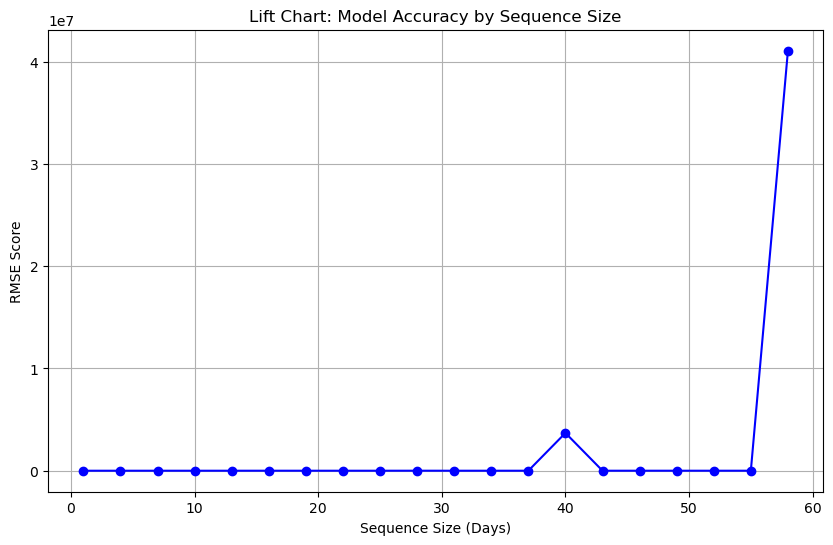

In [12]:
best_sequence_size = sequence_sizes[minIndex]
plt.figure(figsize=(10, 6))
plt.plot(sequence_sizes, rmse_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Sequence Size (Days)')
plt.ylabel('RMSE Score')
plt.title('Lift Chart: Model Accuracy by Sequence Size')
plt.grid(True)
plt.show()


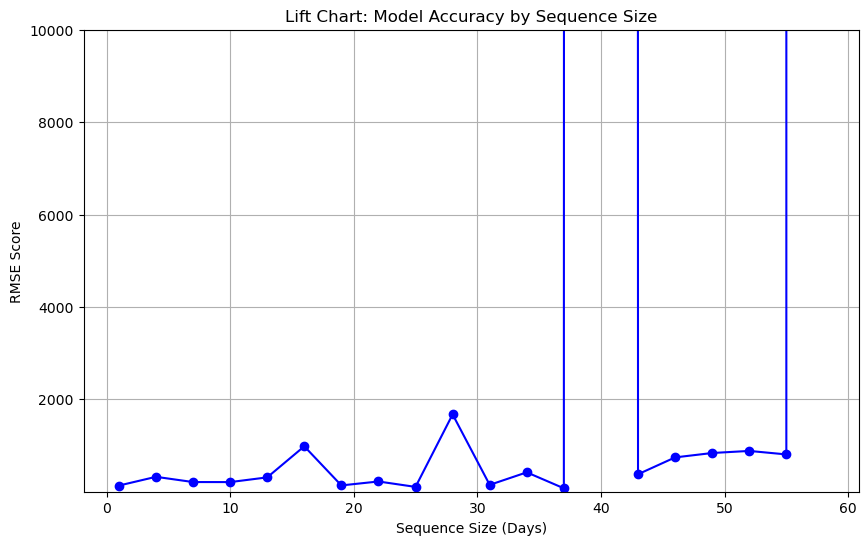

In [ ]:
best_sequence_size = sequence_sizes[minIndex]
plt.figure(figsize=(10, 6))
plt.plot(sequence_sizes, rmse_scores, marker='o', linestyle='-', color='b')
plt.xlabel('Sequence Size (Days)')
plt.ylabel('RMSE Score')
plt.title('Lift Chart: Model Accuracy by Sequence Size')
plt.ylim(1, 10000)
plt.grid(True)
plt.show()
